# Model training using synthetic data - October 2025

## Fase 1: Importaciones y Métricas Personalizadas

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Librerías del modelo de Keras
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD, Adam
from keras import callbacks
import tensorflow.keras.backend as K
from keras.models import load_model

# --- MÉTRICAS PERSONALIZADAS (de tu notebook original) ---
# Estas métricas son excelentes para evaluar el rendimiento
# en problemas de clasificación como el nuestro.

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

print("Fase 1 completada: Librerías importadas y métricas definidas.")

2025-10-16 20:08:24.889933: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Fase 1 completada: Librerías importadas y métricas definidas.


## Fase 2: Carga y Preparación de Datos

In [3]:
# --- Carga de los nuevos datasets ---
# Asegúrate de que las rutas a tus archivos sean correctas
try:
    X = pd.read_csv('features_oclusion_mejorada.csv', header=None)
    y = pd.read_csv('labels_oclusion_mejorada.csv', header=None)
    print("Archivos CSV cargados exitosamente.")
except FileNotFoundError:
    print("Error: No se encontraron los archivos del dataset. Verifica las rutas.")
    # Detener la ejecución si no se encuentran los archivos
    assert False, "Deteniendo ejecución por falta de archivos."


# --- Separación en Train/Test ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2, # 20% para pruebas
    random_state=42 # Para reproducibilidad
)

print(f"Forma de X_train: {X_train.shape}")
print(f"Forma de y_train: {y_train.shape}")
print(f"Forma de X_test: {X_test.shape}")
print(f"Forma de y_test: {y_test.shape}")


# --- Normalización de Features (CORREGIDA)---
# Calculamos la media y std SOLO del set de entrenamiento
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)

# >> INICIO DE LA CORRECCIÓN <<
# Se añade un valor muy pequeño (epsilon) a la desviación estándar 
# para evitar la división por cero en columnas con varianza nula.
epsilon = 1e-7
X_train = (X_train - mean) / (std + epsilon)
X_test = (X_test - mean) / (std + epsilon)

# Verificamos si hay algún valor NaN después de la normalización
if np.isnan(X_train.values).any():
    print("\\nAlerta: Se encontraron valores NaN en X_train después de la normalización.")
else:
    print("\\nNormalización segura completada. No se encontraron NaNs.")
# >> FIN DE LA CORRECCIÓN <<

# Convertir a arrays de numpy para Keras
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

print("\\nFase 2 completada: Datos cargados, separados y normalizados correctamente.")

Archivos CSV cargados exitosamente.
Forma de X_train: (16000, 244)
Forma de y_train: (16000, 3108)
Forma de X_test: (4000, 244)
Forma de y_test: (4000, 3108)
\nNormalización segura completada. No se encontraron NaNs.
\nFase 2 completada: Datos cargados, separados y normalizados correctamente.


## Fase 3: Definición del Modelo Multi-Etiqueta

In [ ]:
X_train.shape

In [4]:
# --- Definición de la Arquitectura de la Red Neuronal ---

# Obtener las dimensiones de entrada y salida de los datos
input_dim = X_train.shape[1]
output_dim = y_train.shape[1]

model = Sequential()

# Capa de entrada y primera capa oculta
model.add(Dense(256, input_dim=input_dim, activation='relu'))
model.add(Dropout(0.5)) # Dropout para regularización

# Segunda capa oculta
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# --- CAMBIO CLAVE: Capa de Salida para Multi-Etiqueta ---
model.add(Dense(output_dim, activation='sigmoid'))

# --- CAMBIO CLAVE: Compilación para Multi-Etiqueta ---
model.compile(
    loss='binary_crossentropy', # Función de pérdida correcta
    optimizer=Adam(learning_rate=0.001), # Adam suele ser un buen optimizador de partida
    metrics=['accuracy', f1_m, precision_m, recall_m]
)

model.summary()
print("\nFase 3 completada: Modelo definido y compilado para clasificación multi-etiqueta.")

/home/juan/anaconda3/envs/tfg/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        62,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3108)           │       400,932 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 496,548 (1.89 MB)

 Trainable params: 496,548 (1.89 MB)

 Non-trainable params: 0 (0.00 B)


Fase 3 completada: Modelo definido y compilado para clasificación multi-etiqueta.


## Fase 4: Entrenamiento y Evaluación del Modelo

Iniciando el entrenamiento del modelo...
Epoch 1/100
497/500 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0034 - f1_m: 2.8969e-04 - loss: 0.0829 - precision_m: 1.4831e-04 - recall_m: 0.0260
Epoch 1: val_f1_m improved from None to 0.00000, saving model to sonar_model_multiobjeto.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.0045 - f1_m: 6.3483e-05 - loss: 0.0248 - precision_m: 3.2626e-05 - recall_m: 0.0049 - val_accuracy: 0.0095 - val_f1_m: 0.0000e+00 - val_loss: 0.0075 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0063 - f1_m: 0.0000e+00 - loss: 0.0081 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00
Epoch 2: val_f1_m did not improve from 0.00000
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.0072 - f1_m: 0.0000e+00 - loss: 0.0080 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_accuracy: 0.0105 - val_f1_m: 0.0000e+00 - val_loss: 0.0073 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 3/100
495/500 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0111 - f1_m: 7.6136e-06 - loss: 0.0078 - precision_m: 3.9382e-04 - recall_m: 3.8440e-06
Epoch 3: val_f1_m did not improve from 0.00000
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.0115 - f1_m: 7

500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.0191 - f1_m: 0.0024 - loss: 0.0073 - precision_m: 0.0732 - recall_m: 0.0012 - val_accuracy: 0.0422 - val_f1_m: 3.3021e-04 - val_loss: 0.0064 - val_precision_m: 0.0160 - val_recall_m: 1.6683e-04
Epoch 5/100
494/500 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0278 - f1_m: 0.0047 - loss: 0.0069 - precision_m: 0.1294 - recall_m: 0.0024
Epoch 5: val_f1_m improved from 0.00033 to 0.00134, saving model to sonar_model_multiobjeto.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.0306 - f1_m: 0.0057 - loss: 0.0069 - precision_m: 0.1432 - recall_m: 0.0029 - val_accuracy: 0.0690 - val_f1_m: 0.0013 - val_loss: 0.0060 - val_precision_m: 0.0547 - val_recall_m: 6.8022e-04
Epoch 6/100
496/500 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0385 - f1_m: 0.0114 - loss: 0.0065 - precision_m: 0.2542 - recall_m: 0.0059
Epoch 6: val_f1_m improved from 0.00134 to 0.00761, saving model to sonar_model_multiobjeto.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.0401 - f1_m: 0.0125 - loss: 0.0065 - precision_m: 0.2759 - recall_m: 0.0065 - val_accuracy: 0.0675 - val_f1_m: 0.0076 - val_loss: 0.0055 - val_precision_m: 0.2493 - val_recall_m: 0.0039
Epoch 7/100
494/500 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0477 - f1_m: 0.0163 - loss: 0.0062 - precision_m: 0.2774 - recall_m: 0.0085
Epoch 7: val_f1_m improved from 0.00761 to 0.01120, saving model to sonar_model_multiobjeto.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.0476 - f1_m: 0.0171 - loss: 0.0062 - precision_m: 0.2733 - recall_m: 0.0090 - val_accuracy: 0.0755 - val_f1_m: 0.0112 - val_loss: 0.0052 - val_precision_m: 0.3253 - val_recall_m: 0.0057
Epoch 8/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0527 - f1_m: 0.0203 - loss: 0.0060 - precision_m: 0.2742 - recall_m: 0.0107
Epoch 8: val_f1_m improved from 0.01120 to 0.01542, saving model to sonar_model_multiobjeto.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.0517 - f1_m: 0.0201 - loss: 0.0060 - precision_m: 0.2671 - recall_m: 0.0106 - val_accuracy: 0.0913 - val_f1_m: 0.0154 - val_loss: 0.0050 - val_precision_m: 0.3679 - val_recall_m: 0.0079
Epoch 9/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0515 - f1_m: 0.0225 - loss: 0.0058 - precision_m: 0.3038 - recall_m: 0.0119
Epoch 9: val_f1_m improved from 0.01542 to 0.02039, saving model to sonar_model_multiobjeto.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.0546 - f1_m: 0.0240 - loss: 0.0058 - precision_m: 0.3075 - recall_m: 0.0127 - val_accuracy: 0.0812 - val_f1_m: 0.0204 - val_loss: 0.0049 - val_precision_m: 0.4348 - val_recall_m: 0.0105
Epoch 10/100
496/500 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0645 - f1_m: 0.0278 - loss: 0.0057 - precision_m: 0.3421 - recall_m: 0.0147
Epoch 10: val_f1_m did not improve from 0.02039
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.0630 - f1_m: 0.0275 - loss: 0.0057 - precision_m: 0.3325 - recall_m: 0.0146 - val_accuracy: 0.1007 - val_f1_m: 0.0151 - val_loss: 0.0048 - val_precision_m: 0.3992 - val_recall_m: 0.0077
Epoch 11/100
495/500 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0637 - f1_m: 0.0311 - loss: 0.0056 - precision_m: 0.3360 - recall_m: 0.0166
Epoch 11: val_f1_m improved from 0.02039 to 0.02867, saving model to sonar_model_multiobjeto.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.0634 - f1_m: 0.0298 - loss: 0.0056 - precision_m: 0.3198 - recall_m: 0.0159 - val_accuracy: 0.0975 - val_f1_m: 0.0287 - val_loss: 0.0048 - val_precision_m: 0.4599 - val_recall_m: 0.0150
Epoch 12/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0690 - f1_m: 0.0354 - loss: 0.0055 - precision_m: 0.3609 - recall_m: 0.0188
Epoch 12: val_f1_m improved from 0.02867 to 0.03300, saving model to sonar_model_multiobjeto.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.0684 - f1_m: 0.0335 - loss: 0.0056 - precision_m: 0.3488 - recall_m: 0.0178 - val_accuracy: 0.1015 - val_f1_m: 0.0330 - val_loss: 0.0047 - val_precision_m: 0.5233 - val_recall_m: 0.0172
Epoch 13/100
497/500 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0699 - f1_m: 0.0345 - loss: 0.0054 - precision_m: 0.3598 - recall_m: 0.0184
Epoch 13: val_f1_m improved from 0.03300 to 0.03306, saving model to sonar_model_multiobjeto.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.0677 - f1_m: 0.0340 - loss: 0.0055 - precision_m: 0.3429 - recall_m: 0.0182 - val_accuracy: 0.0910 - val_f1_m: 0.0331 - val_loss: 0.0047 - val_precision_m: 0.4805 - val_recall_m: 0.0174
Epoch 14/100
495/500 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0694 - f1_m: 0.0354 - loss: 0.0054 - precision_m: 0.3563 - recall_m: 0.0189
Epoch 14: val_f1_m improved from 0.03306 to 0.03352, saving model to sonar_model_multiobjeto.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.0691 - f1_m: 0.0359 - loss: 0.0054 - precision_m: 0.3454 - recall_m: 0.0192 - val_accuracy: 0.1000 - val_f1_m: 0.0335 - val_loss: 0.0046 - val_precision_m: 0.4994 - val_recall_m: 0.0176
Epoch 15/100
497/500 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0695 - f1_m: 0.0397 - loss: 0.0054 - precision_m: 0.3699 - recall_m: 0.0213
Epoch 15: val_f1_m improved from 0.03352 to 0.04213, saving model to sonar_model_multiobjeto.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.0714 - f1_m: 0.0396 - loss: 0.0054 - precision_m: 0.3713 - recall_m: 0.0213 - val_accuracy: 0.1007 - val_f1_m: 0.0421 - val_loss: 0.0046 - val_precision_m: 0.5465 - val_recall_m: 0.0222
Epoch 16/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0752 - f1_m: 0.0434 - loss: 0.0053 - precision_m: 0.3650 - recall_m: 0.0234
Epoch 16: val_f1_m did not improve from 0.04213
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.0723 - f1_m: 0.0422 - loss: 0.0053 - precision_m: 0.3680 - recall_m: 0.0227 - val_accuracy: 0.0970 - val_f1_m: 0.0374 - val_loss: 0.0046 - val_precision_m: 0.5183 - val_recall_m: 0.0196
Epoch 17/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0784 - f1_m: 0.0434 - loss: 0.0053 - precision_m: 0.3819 - recall_m: 0.0233
Epoch 17: val_f1_m did not improve from 0.04213
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.0781 - f1_m: 0.0429 - loss: 0.0053 - precision_m: 0.3746 - recall_m: 0.0231 - v

500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.0782 - f1_m: 0.0433 - loss: 0.0051 - precision_m: 0.3686 - recall_m: 0.0233 - val_accuracy: 0.1002 - val_f1_m: 0.0445 - val_loss: 0.0044 - val_precision_m: 0.5092 - val_recall_m: 0.0235
Epoch 22/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0791 - f1_m: 0.0484 - loss: 0.0051 - precision_m: 0.3929 - recall_m: 0.0262
Epoch 22: val_f1_m did not improve from 0.04450
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.0793 - f1_m: 0.0473 - loss: 0.0051 - precision_m: 0.3891 - recall_m: 0.0256 - val_accuracy: 0.1110 - val_f1_m: 0.0411 - val_loss: 0.0044 - val_precision_m: 0.5432 - val_recall_m: 0.0216
Epoch 23/100
496/500 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0802 - f1_m: 0.0482 - loss: 0.0050 - precision_m: 0.3948 - recall_m: 0.0261
Epoch 23: val_f1_m did not improve from 0.04450
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.0777 - f1_m: 0.0469 - loss: 0.0051 - precision_m: 0.3815 - recall_m: 0.0254 - v

500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.0814 - f1_m: 0.0461 - loss: 0.0051 - precision_m: 0.3717 - recall_m: 0.0250 - val_accuracy: 0.1077 - val_f1_m: 0.0475 - val_loss: 0.0044 - val_precision_m: 0.5579 - val_recall_m: 0.0252
Epoch 25/100
494/500 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0894 - f1_m: 0.0445 - loss: 0.0050 - precision_m: 0.3678 - recall_m: 0.0241
Epoch 25: val_f1_m did not improve from 0.04755
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.0841 - f1_m: 0.0461 - loss: 0.0050 - precision_m: 0.3793 - recall_m: 0.0249 - val_accuracy: 0.1058 - val_f1_m: 0.0435 - val_loss: 0.0044 - val_precision_m: 0.5531 - val_recall_m: 0.0229
Epoch 26/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0776 - f1_m: 0.0483 - loss: 0.0049 - precision_m: 0.3891 - recall_m: 0.0261
Epoch 26: val_f1_m did not improve from 0.04755
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.0784 - f1_m: 0.0483 - loss: 0.0050 - precision_m: 0.3964 - recall_m: 0.0262 - v

500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.0880 - f1_m: 0.0522 - loss: 0.0049 - precision_m: 0.4077 - recall_m: 0.0283 - val_accuracy: 0.1065 - val_f1_m: 0.0497 - val_loss: 0.0043 - val_precision_m: 0.5501 - val_recall_m: 0.0263
Epoch 32/100
495/500 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0918 - f1_m: 0.0533 - loss: 0.0049 - precision_m: 0.4118 - recall_m: 0.0289
Epoch 32: val_f1_m did not improve from 0.04969
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.0893 - f1_m: 0.0506 - loss: 0.0049 - precision_m: 0.4009 - recall_m: 0.0274 - val_accuracy: 0.1105 - val_f1_m: 0.0429 - val_loss: 0.0043 - val_precision_m: 0.5691 - val_recall_m: 0.0225
Epoch 33/100
496/500 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0888 - f1_m: 0.0524 - loss: 0.0048 - precision_m: 0.4091 - recall_m: 0.0284
Epoch 33: val_f1_m did not improve from 0.04969
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.0861 - f1_m: 0.0507 - loss: 0.0049 - precision_m: 0.3968 - recall_m: 0.0275 - v

500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.0908 - f1_m: 0.0532 - loss: 0.0048 - precision_m: 0.4076 - recall_m: 0.0289 - val_accuracy: 0.1055 - val_f1_m: 0.0499 - val_loss: 0.0043 - val_precision_m: 0.6050 - val_recall_m: 0.0263
Epoch 38/100
496/500 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0964 - f1_m: 0.0584 - loss: 0.0048 - precision_m: 0.4307 - recall_m: 0.0318
Epoch 38: val_f1_m did not improve from 0.04993
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.0906 - f1_m: 0.0562 - loss: 0.0048 - precision_m: 0.4190 - recall_m: 0.0306 - val_accuracy: 0.1100 - val_f1_m: 0.0457 - val_loss: 0.0042 - val_precision_m: 0.5669 - val_recall_m: 0.0241
Epoch 39/100
494/500 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0934 - f1_m: 0.0547 - loss: 0.0048 - precision_m: 0.3996 - recall_m: 0.0297
Epoch 39: val_f1_m did not improve from 0.04993
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.0911 - f1_m: 0.0565 - loss: 0.0048 - precision_m: 0.3974 - recall_m: 0.0308 - v

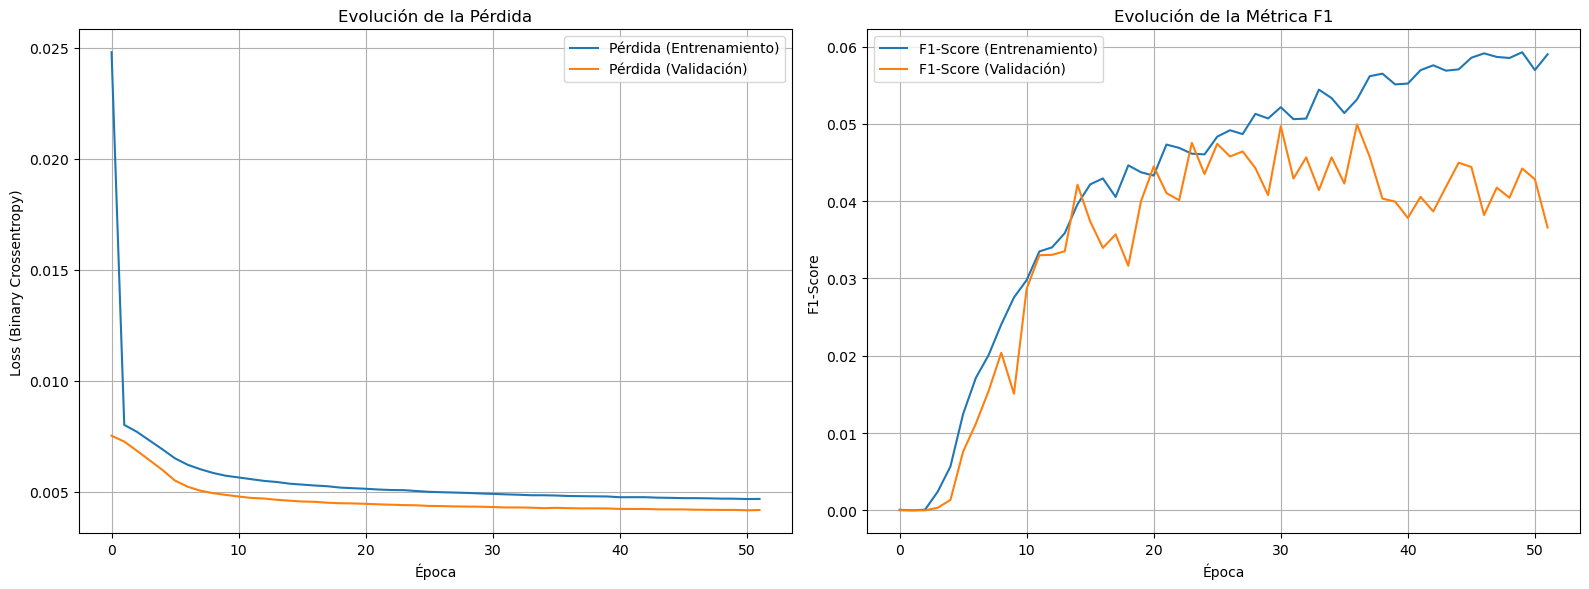

In [5]:
# ===================================================================
# FASE 4: Entrenamiento y Evaluación del Modelo
# ===================================================================

# --- Configuración de Callbacks ---
# Guardará el mejor modelo basado en la métrica F1 del set de validación.
model_checkpoint = callbacks.ModelCheckpoint(
    'sonar_model_multiobjeto.h5', # Nombre del archivo para el nuevo modelo
    monitor='val_f1_m', # Métrica a monitorear
    verbose=1,
    save_best_only=True,
    mode='max' # Guardar cuando la métrica F1 sea máxima
)

# Detendrá el entrenamiento si la métrica F1 no mejora después de 'patience' épocas.
early_stopping = callbacks.EarlyStopping(
    monitor='val_f1_m',
    patience=15, # Número de épocas a esperar por una mejora
    mode='max',
    restore_best_weights=True # Restaura los pesos del mejor modelo al final
)

# --- Entrenamiento del Modelo ---
print("Iniciando el entrenamiento del modelo...")

history = model.fit(
    X_train, y_train,
    epochs=100, # Un número alto de épocas, EarlyStopping se encargará de detenerlo
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[model_checkpoint, early_stopping]
)

print("\nEntrenamiento finalizado.")

# --- Visualización del Historial de Entrenamiento ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico de Pérdida (Loss)
axes[0].plot(history.history['loss'], label='Pérdida (Entrenamiento)')
axes[0].plot(history.history['val_loss'], label='Pérdida (Validación)')
axes[0].set_title('Evolución de la Pérdida')
axes[0].set_xlabel('Época')
axes[0].set_ylabel('Loss (Binary Crossentropy)')
axes[0].legend()
axes[0].grid(True)

# Gráfico de la Métrica F1
axes[1].plot(history.history['f1_m'], label='F1-Score (Entrenamiento)')
axes[1].plot(history.history['val_f1_m'], label='F1-Score (Validación)')
axes[1].set_title('Evolución de la Métrica F1')
axes[1].set_xlabel('Época')
axes[1].set_ylabel('F1-Score')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [8]:
# --- Evaluación Final en el Set de Prueba ---
print("\nEvaluando el modelo final en el conjunto de prueba:")
score = model.evaluate(X_test, y_test, verbose=1)

print(f"\nResultados en el Test Set:")
print(f"  Pérdida (Loss): {score[0]:.4f}")
print(f"  Accuracy: {score[1]:.4f}")
print(f"  F1-Score: {score[2]:.4f}")
print(f"  Precision: {score[3]:.4f}")
print(f"  Recall: {score[4]:.4f}")

# --- Ejemplo de Predicción ---
print("\nEjemplo de predicción en una muestra del test set:")
# Hacemos la predicción sobre todo el set de prueba
y_pred_probs = model.predict(X_test)

# Definimos un umbral para decidir si un cuadrante está "activo"
umbral_prediccion = 0.5
y_pred = (y_pred_probs > umbral_prediccion).astype(int)

# Elegimos una muestra al azar para comparar
indice_ejemplo = np.random.randint(0, len(y_test))

cuadrantes_reales = np.where(y_test[indice_ejemplo] == 1)[0]
cuadrantes_predichos = np.where(y_pred[indice_ejemplo] == 1)[0]

print(f"\n--- Muestra #{indice_ejemplo} ---")
print(f"Cuadrantes Reales:     {cuadrantes_reales}")
print(f"Cuadrantes Predichos:  {cuadrantes_predichos}")


Evaluando el modelo final en el conjunto de prueba:
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1055 - f1_m: 0.0499 - loss: 0.0043 - precision_m: 0.6050 - recall_m: 0.0263

Resultados en el Test Set:
  Pérdida (Loss): 0.0043
  Accuracy: 0.1055
  F1-Score: 0.0499
  Precision: 0.6050
  Recall: 0.0263

Ejemplo de predicción en una muestra del test set:
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

--- Muestra #1759 ---
Cuadrantes Reales:     [2222 2223 2260 2373]
Cuadrantes Predichos:  []
